In [25]:
import os
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn
from sklearn.metrics import f1_score,recall_score,precision_score

In [26]:
def build_dict(lists):
    f={}
    for _list in lists:
        for item in _list:
            if item not in f:
                f[item]=len(f)
    return f

def build_corpus(dataset):
    if dataset=='train':
        word_lists = []
        tag_lists = []
        with open('./data/demo.train.char','r',encoding='utf-8') as f:
            word_list,tag_list=[],[]
            for line in f:
                if line != '\n':
                        word, tag = line.strip('\n').split(' ')
                        word_list.append(word)
                        tag_list.append(tag)
                else:
                    word_lists.append(word_list)
                    tag_lists.append(tag_list)
                    word_list,tag_list=[],[]
        word_lists.sort(key=lambda x: len(x), reverse=True)
        tag_lists.sort(key=lambda x: len(x), reverse=True)

        # print(word_lists,tag_lists)

        word2index=build_dict(word_lists)
        tag2index=build_dict(tag_lists)
        word2index['<UNK>']=len(word2index)
        word2index['<PAD>']=len(word2index)
        tag2index['<PAD>']=len(tag2index)
        index2word=dict((word2index[key], key) for key in word2index)
        index2tag=dict((tag2index[key], key) for key in tag2index)
        return word_lists,tag_lists,word2index,tag2index,index2word,index2tag
    elif dataset=='test':
        word_lists = []
        tag_lists = []
        with open('./data/demo.test.char','r',encoding='utf-8') as f:
            word_list,tag_list=[],[]
            for line in f:
                if line != '\n':
                        word, tag = line.strip('\n').split(' ')
                        word_list.append(word)
                        tag_list.append(tag)
                else:
                    word_lists.append(word_list)
                    tag_lists.append(tag_list)
                    word_list,tag_list=[],[]
        word_lists.sort(key=lambda x: len(x), reverse=True)
        tag_lists.sort(key=lambda x: len(x), reverse=True)
        return word_lists,tag_lists

In [27]:
class MyDataset(Dataset):
    def __init__(self, _word_lists, _tag_lists, _word2index: dict, _tag2index: dict):
        super().__init__()
        self.word_lists=_word_lists
        self.tag_lists=_tag_lists
        self.word2index=_word2index
        self.tag2index=_tag2index

    def __len__(self):
        return len(self.word_lists)

    def __getitem__(self, index):
        word_list=self.word_lists[index]
        tag_list=self.tag_lists[index]
        word_index=[self.word2index.get(i,self.word2index["<UNK>"]) for i in word_list]
        tag_index=[self.tag2index[i] for i in tag_list]
        return word_index,tag_index

    def pro_batch_data(self,batch_datas):
        global device
        lenth=len(batch_datas[0][0])
        datas,tags=[],[]
        for data,tag in batch_datas:
            datas.append(data)
            tags.append(tag)

        datas = [i + [self.word2index["<PAD>"]] * (lenth - len(i)) for i in datas]
        tags = [i + [self.tag2index["<PAD>"]] * (lenth - len(i)) for i in tags]

        return torch.tensor(datas,dtype=torch.int64,device=device),torch.tensor(tags,dtype=torch.int64,device=device)

In [28]:
class BiLstm(nn.Module):
    def __init__(self,corpus_num,embedding_num,hidden_num,class_num,bi=True):
        super().__init__()
        self.embedding = nn.Embedding(corpus_num,embedding_num)
        self.lstm = nn.LSTM(embedding_num,hidden_num,batch_first=True,bidirectional=bi)
        if bi:
            self.fc=nn.Linear(hidden_num*2,class_num)
        else:
            self.fc=nn.Linear(hidden_num,class_num)

    def forward(self, batch_data):
        embedding=self.embedding(batch_data)
        out,_=self.lstm(embedding)
        return self.fc(out)

In [29]:
word_lists,tag_lists,word2index,tag2index,index2word,index2tag=build_corpus('train')
device='cuda:0'
batch_size=32
train_dataset = MyDataset(word_lists,tag_lists,word2index,tag2index)
train_dataloader = DataLoader(train_dataset,batch_size,shuffle=False,collate_fn=train_dataset.pro_batch_data)
lr=0.005
epochs=30



In [30]:
test_word_lists,test_tag_lists=build_corpus('test')

test_dataset = MyDataset(test_word_lists,test_tag_lists,word2index,tag2index)
test_dataloader = DataLoader(test_dataset,batch_size,shuffle=False,collate_fn=test_dataset.pro_batch_data)

In [31]:
model=BiLstm(len(word2index),100,100,len(tag2index)).to(device)
model.train()
loss=nn.CrossEntropyLoss()
opt=torch.optim.Adam(model.parameters(), lr=lr)

loss_list,f1_list=[],[]
for epoch in range(epochs):
    all_loss=0
    model.train()
    for word,tag in train_dataloader:

        opt.zero_grad()
        tag_hat=model.forward(word)
        l=loss(tag_hat.reshape(-1,len(tag2index)),tag.reshape(-1,1).squeeze())
        l.backward()
        opt.step()
        all_loss+=l.item()
    model.eval()
    with torch.no_grad():
        all_pre,all_tag=[],[]
        for word,tag in test_dataloader:
            tag_hat=model.forward(word)
            all_pre.extend(tag_hat.argmax(2).reshape(-1).detach().cpu().numpy().tolist())
            all_tag.extend(tag.reshape(-1).detach().cpu().numpy().tolist())
        f1=f1_score(all_tag,all_pre,average="micro")
    f1_list.append(f1)
    loss_list.append(all_loss/len(train_dataloader))
    print(f'epoch: {epoch+1}, loss: {all_loss/len(train_dataloader):.4f}')

epoch: 1, loss: 1.0569
epoch: 2, loss: 0.5176
epoch: 3, loss: 0.3421
epoch: 4, loss: 0.2117
epoch: 5, loss: 0.1343
epoch: 6, loss: 0.0886
epoch: 7, loss: 0.0643
epoch: 8, loss: 0.0491
epoch: 9, loss: 0.0376
epoch: 10, loss: 0.0290
epoch: 11, loss: 0.0225
epoch: 12, loss: 0.0196
epoch: 13, loss: 0.0133
epoch: 14, loss: 0.0082
epoch: 15, loss: 0.0057
epoch: 16, loss: 0.0042
epoch: 17, loss: 0.0034
epoch: 18, loss: 0.0027
epoch: 19, loss: 0.0022
epoch: 20, loss: 0.0019
epoch: 21, loss: 0.0019
epoch: 22, loss: 0.0018
epoch: 23, loss: 0.0013
epoch: 24, loss: 0.0011
epoch: 25, loss: 0.0009
epoch: 26, loss: 0.0009
epoch: 27, loss: 0.0007
epoch: 28, loss: 0.0006
epoch: 29, loss: 0.0006
epoch: 30, loss: 0.0005


In [32]:

model.eval()
all_pre,all_tag=[],[]
for word,tag in test_dataloader:
    tag_hat=model.forward(word)
    all_pre.extend(tag_hat.argmax(2).reshape(-1).detach().cpu().numpy().tolist())
    all_tag.extend(tag.reshape(-1).detach().cpu().numpy().tolist())
f1=f1_score(all_tag,all_pre,labels=list(range(len(tag2index))),average="micro")
print(f1)

0.9390482398956975


In [33]:
s=input()
a=[word2index.get(i, word2index['<UNK>']) for i in s]
word=torch.tensor(a,dtype=torch.int64,device=device).unsqueeze(0)
tag_hat=model.forward(word)
tag_hat=tag_hat.reshape(-1,tag_hat.shape[-1])
word=word.reshape(-1)
pre=tag_hat.argmax(1)
for id,item in enumerate(pre):
    item=item.item()
    if item and index2tag[item]!='<PAD>':
        print(index2word[word[id].item()],index2tag[item])

北 B-GPE
京 E-GPE
中 B-GPE
国 E-GPE


In [34]:
# torch.save(model,'bilstm.pth')

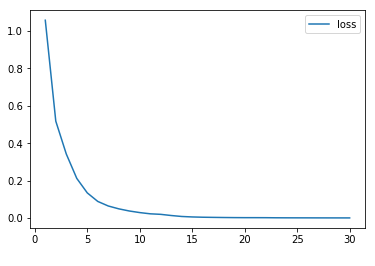

In [36]:
from matplotlib import pyplot as plt
plt.xlabel('epoch',color='white')
plt.ylabel('',color='white')
x=list(range(1,epochs+1))
plt.plot(x,loss_list,label='loss')
plt.legend()
plt.show()